In [1]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import mglearn

/home/alex/3rd/py-venv/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/home/alex/3rd/py-venv/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


## 2.4 分类器的不确定度估计
`scikit-learn`的分类器能够给出预测的不确定度估计。一般来说，你感兴趣的不仅是分类器会预测一个测试点属于哪个类别，还包括它对这个预测的置信程度。在实践中，不同类型的错误会在现实应用中导致非常不同的结果。想象一个用于测试癌症的医疗应用。假阳性预测可能只会让患者接受额外的测试，但假阴性预测却可能导致重病没有得到治疗。第6章会进一步探讨这一主题。

`scikit-learn`中有两个函数可用于获取分类器的不确定度估计：`decision_function`和`predict_proba`。大多数分类器都至少有其中一个函数，很多分类器两个都有。我们通过`GradientBoostingClassifier分类器`演示这两个函数的作用：

In [17]:
X, y = make_circles(noise=0.25, factor=0.5, random_state=1)

# 为了便于说明，我们将两个类别重命名为"blue"和"red"
y_named = np.array(["blue", "red"])[y]

# 我们可以对任意个数组调用train_test_split
# 所有数组的划分方式都是一致的
X_train, X_test, y_train_named, y_test_named, y_train, y_test = train_test_split(X, y_named, y, random_state=0)

# 构建梯度提升模型
gbrt = GradientBoostingClassifier(random_state=0)
gbrt.fit(X_train, y_train_named)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

#### 2.4.4.1 决策函数
对于二分类的情况，`decision_function`为每个样本都返回一个浮点数：

In [3]:
print("X_test.shape: {}".format(X_test.shape))
print("Decision function shape: {}".format(gbrt.decision_function(X_test).shape))

X_test.shape: (25, 2)
Decision function shape: (25,)


这个值表示模型对该数据点属于“正”类的置信程度。正值表示对正类的偏好，负值表示对“反类”的偏好。我们可以通过查看决策函数的正负号来预测：

In [4]:
# 显示decision_function的前几个元素
print("Decision function:\n{}\n".format(gbrt.decision_function(X_test)[:6]))
print("Thresholded decision function:\n{}\n".format(gbrt.decision_function(X_test)[:6] > 0))
print("Predictions:\n{}".format(gbrt.predict(X_test)[:6]))

Decision function:
[ 4.13592629 -1.7016989  -3.95106099 -3.62599351  4.28986668  3.66166106]

Thresholded decision function:
[ True False False False  True  True]

Predictions:
['red' 'blue' 'blue' 'blue' 'red' 'red']


对于二分类问题，“反”类始终是`classes_`属性的第一个元素，“正”类是`classes_`的第二个元素。如果要完全再现`predict`的输出，需要利用`classes_`属性：

In [5]:
# 将布尔值True/False转换成0和1
greater_zero = (gbrt.decision_function(X_test) > 0).astype(int)
# 利用0和1作为classes_的索引
pred = gbrt.classes_[greater_zero]
# pred与gbrt.predict的输出完全相同
print("pred is equal to predictions: {}".format(np.all(pred == gbrt.predict(X_test))))

pred is equal to predictions: True


`decision_function`可以在任意范围取值，这取决于数据与模型参数：

In [6]:
decision_function = gbrt.decision_function(X_test)
print("Decision function minimum: {:.2f} maximum: {:.2f}".format(
    np.min(decision_function), np.max(decision_function)))

Decision function minimum: -7.69 maximum: 4.29


由于可以任意缩放，因此`decision_function`的输出往往很难解释。我们利用颜色编码在二维平面中画出所有点的`decision_function`，还有决策边界。我们将训练点画成圆，将测试数据画成三角：

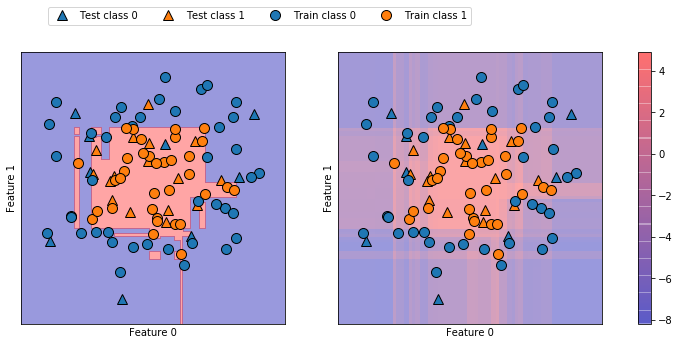

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

mglearn.tools.plot_2d_separator(gbrt, X, ax=axes[0], alpha=.4, fill=True, cm=mglearn.cm2)
scores_image = mglearn.tools.plot_2d_scores(gbrt, X, ax=axes[1], alpha=.4, cm=mglearn.ReBl)

for ax in axes:
    # 画出训练点和测试点
    mglearn.discrete_scatter(X_test[:, 0], X_test[:, 1], y_test, markers='^', ax=ax)
    mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train, markers='o', ax=ax)
    ax.set_xlabel("Feature 0")
    ax.set_ylabel("Feature 1")

cbar = plt.colorbar(scores_image, ax=axes.tolist())
axes[0].legend(["Test class 0", "Test class 1", "Train class 0", "Train class 1"], ncol=4, loc=(.1, 1.1))
plt.show()

既给出预测结果，又给出分类器的置信程度，这样给出的信息量更大。但在上面的图像中，很难分辨出两个类别之间的边界。

#### 2.4.4.2 预测概率
`predict_proba`的输出是每个类别的概率，通常比`decision_function`的输出更容易理解。`predict_proba`函数输出的每行的第一个元素是第一个类别的估计概率，第二个元素是第二个类别的估计概率。由于 predict_proba 的输出是一个概率，因此总是在 0 和 1 之间，两个类别的元素之和始终为 1：

In [8]:
print("Shape of probabilities: {}".format(gbrt.predict_proba(X_test).shape))

# 显示predict_proba的前几个元素
print("Predicted probabilities:\n{}".format(gbrt.predict_proba(X_test[:6])))

Shape of probabilities: (25, 2)
Predicted probabilities:
[[0.01573626 0.98426374]
 [0.84575649 0.15424351]
 [0.98112869 0.01887131]
 [0.97406775 0.02593225]
 [0.01352142 0.98647858]
 [0.02504637 0.97495363]]


如果一个类别的概率超过50%，这个类别就是模型的预测结果。

由于概率是浮点数，所以不太可能两个都等于0.500。但如果出现了这种情况，预测结果是随机选择的。

***从输出可以看到，分类器对大部分点的置信程度都是相对较高的。不确定度大小实际上反映了数据依赖于模型和参数的不确定度。过拟合更强的模型可能会做出置信程度更高的预测，即使可能是错的。复杂度越低的模型通常对预测的不确定度越大。如果模型给出的不确定度符合实际情况，那么这个模型被称为校正（calibrated）模型。在校正模型中，如果预测有70%的确定度，那么它在70%的情况下正确。***

下面的例子给出该数据集的决策边界，以及类别1的类别概率：

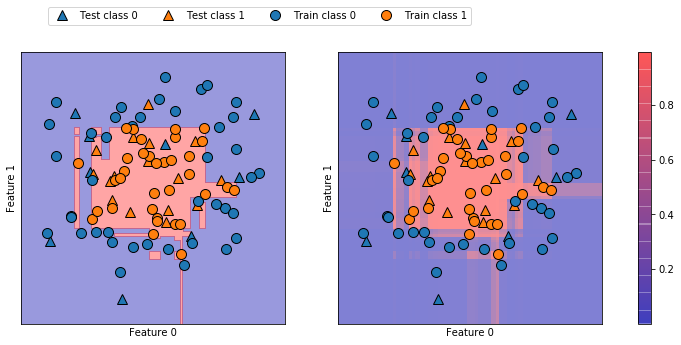

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

mglearn.tools.plot_2d_separator(gbrt, X, ax=axes[0], alpha=.4, fill=True, cm=mglearn.cm2)
scores_image = mglearn.tools.plot_2d_scores(gbrt, X, ax=axes[1], alpha=.5, cm=mglearn.ReBl, function='predict_proba')

for ax in axes:
    # 画出训练点和测试点
    mglearn.discrete_scatter(X_test[:, 0], X_test[:, 1], y_test, markers='^', ax=ax)
    mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train, markers='o', ax=ax)
    ax.set_xlabel("Feature 0")
    ax.set_ylabel("Feature 1")

cbar = plt.colorbar(scores_image, ax=axes.tolist())
axes[0].legend(["Test class 0", "Test class 1", "Train class 0", "Train class 1"], ncol=4, loc=(.1, 1.1))
plt.show()

这张图中的边界更加明确，不确定的小块区域清晰可见。

`scikit-learn`网站给出了许多模型的对比，以及不确定度估计的形状：

http://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html


#### 2.4.4.3　多分类问题的不确定度
`decision_function`和`predict_proba`也适用于多分类问题。我们将这两个函数应用于Iris数据集，这是一个三分类数据集：

In [10]:
from sklearn.datasets import load_iris

iris = load_iris()
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, random_state=42)

gbrt = GradientBoostingClassifier(learning_rate=0.01, random_state=0)
gbrt.fit(X_train, y_train)

print("Decision function shape: {}\n".format(gbrt.decision_function(X_test).shape))

# 显示决策函数的前几个元素
print("Decision function:\n{}\n".format(gbrt.decision_function(X_test)[:6, :]))

print("Argmax of decision function:\n{}\n".format(np.argmax(gbrt.decision_function(X_test), axis=1)))
print("Predictions:\n{}".format(gbrt.predict(X_test)))

Decision function shape: (38, 3)

Decision function:
[[-1.9957153   0.04758118 -1.92721297]
 [ 0.0614655  -1.90755689 -1.92793177]
 [-1.99058105 -1.87637856  0.09686741]
 [-1.9957153   0.04758118 -1.92721297]
 [-1.99730166 -0.13469231 -1.20341532]
 [ 0.0614655  -1.90755689 -1.92793177]]

Argmax of decision function:
[1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0]

Predictions:
[1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0]


`predict_proba`输出所有可能类别的概率：

In [11]:
# 显示predict_proba的前几个元素
print("Predicted probabilities:\n{}".format(gbrt.predict_proba(X_test)[:6]))
# 显示每行的和都是1
print("Sums: {}".format(gbrt.predict_proba(X_test)[:6].sum(axis=1)))

Predicted probabilities:
[[0.10217734 0.78840063 0.10942203]
 [0.7834712  0.1093673  0.1071615 ]
 [0.09818079 0.11005862 0.79176059]
 [0.10217734 0.78840063 0.10942203]
 [0.10360014 0.66723882 0.22916105]
 [0.7834712  0.1093673  0.1071615 ]]
Sums: [1. 1. 1. 1. 1. 1.]


同样可以通过计算`predict_proba`的`argmax`来再现预测结果：

In [12]:
print("Argmax of predicted probabilities:\n{}".format(np.argmax(gbrt.predict_proba(X_test), axis=1)))
print("Predictions:\n{}".format(gbrt.predict(X_test)))

Argmax of predicted probabilities:
[1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0]
Predictions:
[1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0]


`predict_proba`和`decision_function`的形状始终相同，都是(n_samples, n_classes)。对于二分类的情况，`decision_function`只有一列，对应“正”类`classes_[1]`。这主要是由于历史原因。

如果有`n_classes`列，你可以通过计算每一列的`argmax`来再现预测结果。但如果类别是字符串，或者是整数，但不是从0开始的连续整数的话，一定要小心。如果你想要对比`predict`的结果与`decision_function`或`predict_proba`的结果，一定要用分类器的`classes_`属性来获取真实的属性名称：

In [13]:
logreg = LogisticRegression()

# 用Iris数据集的类别名称来表示每一个目标值
named_target = iris.target_names[y_train]
logreg.fit(X_train, named_target)
print("unique classes in training data: {}".format(logreg.classes_))
print("predictions: {}".format(logreg.predict(X_test)[:10]))

argmax_dec_func = np.argmax(logreg.decision_function(X_test), axis=1)
print("argmax of decision function: {}".format(argmax_dec_func[:10]))
print("argmax combined with classes_: {}".format(logreg.classes_[argmax_dec_func][:10]))

unique classes in training data: ['setosa' 'versicolor' 'virginica']
predictions: ['versicolor' 'setosa' 'virginica' 'versicolor' 'versicolor' 'setosa'
 'versicolor' 'virginica' 'versicolor' 'versicolor']
argmax of decision function: [1 0 2 1 1 0 1 2 1 1]
argmax combined with classes_: ['versicolor' 'setosa' 'virginica' 'versicolor' 'versicolor' 'setosa'
 'versicolor' 'virginica' 'versicolor' 'versicolor']


/home/alex/3rd/py-venv/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/alex/3rd/py-venv/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
